In [2]:
import numpy as np
import matplotlib.pyplot as plt

Unable to revert mtime: /Library/Fonts


In [3]:
data = np.load("data.npy")

In [5]:
# data is sampled at 125hz -> each sample is 8ms
# shape is {up/down/neutral, channel, sample}
data.shape

(3, 16, 1250)

### Data Exploration


1. Chunk out the data into 1s samples

2. Featurize the data & visualize features
    *
    * FFT features
        * can we see 6Hz dominant frequency?
        * can we isolate brain wave bins (alpha, etc.) and plot relative magnitudes?

3. Can we run an unsupervised clustering operation and see broader trends?

In [23]:
# Add the up/down/neutral segments together and transpose the array so it's samples-first
concat = np.concatenate(
    [data[0], data[1], data[2]],
    axis=-1
).T
concat.shape

(3750, 16)

In [26]:
# take the samples and chunk it out into 1s discrete windows
windows = concat.reshape((30, 125, 16))

In [37]:
# do a data check to make sure we've reshaped correctly
# corresponds to "up" trial run, second window
assert np.array_equal(
    data[0,:,125:250].T,
    windows[1]
)

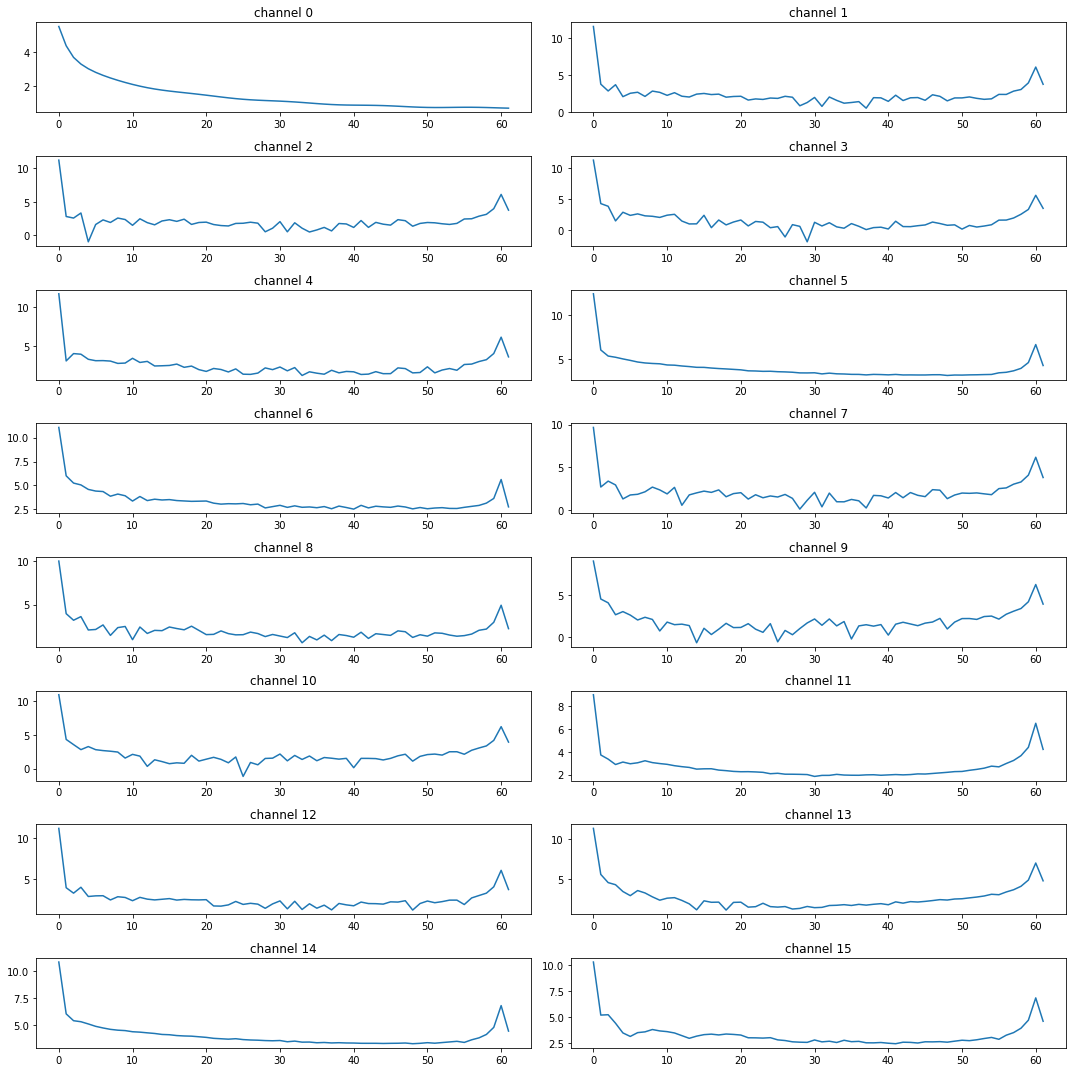

In [96]:
from scipy.fft import fft


def fft_features(sample_window):
    """
    takes an input of (125, 16) and returns (16, 8)
    for each channel, runs a FFT and outputs amplitudes for:

    assumes 1s windows of input.
    """
    
    N = sample_window.shape[0]
    channel_features = []
    for channel in range(sample_window.shape[1]):
        channel_features.append(fft(sample_window[:, channel])[:N//2])
    
    # can also choose to create frequency bins. right now, we're going from 0 -> 61Hz
    
    # log scaling here.
    return np.log(2.0/N * np.abs(np.array(channel_features)))
    

# Make sure that we're doing everything sanely. Plot the FFT for each channel
features = fft_features(windows[0])

fig, axs = plt.subplots(8, 2)
for i in range(features.shape[0]):
    axs[i//2, i%2].set_title(f"channel {i}")
    axs[i//2, i%2].plot(range(62), features[i])

fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout()

In [102]:
# Generate the training dataset
xs = []
ys = []
for i, example in enumerate(windows):
    features = fft_features(example)
    xs.append(features)
    if i < 10:
        ys.append(0)
    elif i < 20:
        ys.append(1)
    else:
        ys.append(2)

xs = np.array(xs)

In [112]:
# reshape for training
xs = xs.reshape((30, -1))
xs.shape

(30, 992)

In [125]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.3, shuffle=True)

In [126]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(max_iter=300).fit(X_train, y_train)
print(f"train score: {clf.score(X_train, y_train)}")
print(f"test score: {clf.score(X_test, y_test)}")

train score: 1.0
test score: 0.5555555555555556


In [127]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["up", "neutral", "down"]))

              precision    recall  f1-score   support

          up       1.00      0.50      0.67         2
     neutral       0.50      0.75      0.60         4
        down       0.50      0.33      0.40         3

    accuracy                           0.56         9
   macro avg       0.67      0.53      0.56         9
weighted avg       0.61      0.56      0.55         9

